<a href="https://colab.research.google.com/github/gandalf1819/Data-Science-portfolio/blob/master/CS6053_Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS6053 Foundations of Data Science
## Homework 4 

Student Name: Chinmay Wyawahare 

Student Netid: cnw282
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import Counter
from sklearn.preprocessing import scale

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def cleanBosonData(infile_name):
    raw=pd.read_csv(infile_name,header=0,index_col=0,na_values=-999)
    raw=raw.replace({'Label':{Counter(raw['Label']).most_common()[0][0]:0,Counter(raw['Label']).most_common()[1][0]:1}}).rename(columns={'Label':'Y'})
    for col in raw.columns.values[:-1]:
        if raw[col].isnull().any().any():
            raw[(col+'_mv')]=np.where(raw[col].isnull(),1,0)
            raw[col]=raw[col].fillna(raw[col].mean())
        raw[col]=scale(raw[col]) # Use StandardScaler from pre-processing library
    return raw

### Part 2: Basic evaluations (5 points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Read and clean the two data files for this assignment (`boson_training_cut_2000.csv` and `boson_testing_cut.csv`) and use them as training and testing data sets. You can find them inside the data folder.

In [0]:
data_train = cleanBosonData("/content/gdrive/My Drive/CS6053_HW4/boson_training_cut_2000.csv")
data_test = cleanBosonData("/content/gdrive/My Drive/CS6053_HW4/boson_testing_cut.csv")

In [0]:
data_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193,0.888048,1.120050,1,0,0,0,0
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,0.000000,1.421917,-0.806390,0,0,1,1,1
100002,-3.235580e-15,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,0.000000,0.997693,-0.455521,0,1,1,1,1
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,0.000000,1.209152,-0.886831,0,0,1,1,1
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,0.000000,1.967534,-0.113790,0,0,1,1,1


In [0]:
data_train.tail()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
101994,-0.416952,0.284974,-0.315544,-0.736215,-4.978417e-16,2.786711e-16,0.000000,0.505594,-0.435363,0,0,1,1,1
101995,-0.089791,-0.623212,-0.025055,0.046088,-4.978417e-16,2.786711e-16,0.000000,-0.017833,-0.814946,1,0,1,1,1
101996,-1.313012,0.091245,-0.994622,0.318724,-4.978417e-16,2.786711e-16,0.000000,-1.710811,-0.802716,0,0,1,1,1
101997,1.843533,0.735452,2.252332,0.372539,1.166337e-01,-7.940977e-01,-0.303829,0.860636,-0.679394,0,0,0,0,0
101998,0.374808,-1.217865,-0.084325,0.522139,-2.460637e+00,-1.365422e+00,3.367369,-0.516459,-0.670403,1,0,0,0,0


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

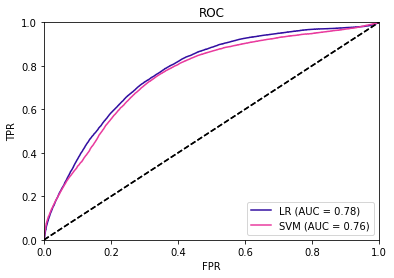

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model,svm
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import linear_model
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

target_var = "Y"
actual = data_test["Y"].copy()

clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(data_train.drop(target_var,1),data_train[target_var])
predictions = clf_LR.predict_proba(data_test.drop(target_var,1))[:,1]

clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(data_train.drop(target_var,1),data_train[target_var])
predictions_svm = clf_svm.decision_function(data_test.drop(target_var,1))

# Creating a model using Logistic regression
logreg = linear_model.LogisticRegression(C = 1e30).fit(data_train.drop('Y', 1), data_train['Y'])
# Creating a model using Support Vector Machines
svm=SVC(kernel="linear").fit(data_train.drop('Y',1),data_train['Y'])

pred_logreg=logreg.predict(data_test.drop('Y',1))
pred_svm=svm.predict(data_test.drop('Y',1))

roc_log=roc_curve(y_true=data_test['Y'],y_score=pred_logreg)
roc_svm=roc_curve(y_true=data_test['Y'],y_score=pred_svm)

# pred_logreg=logreg.predict(data_test.drop('Y',1))
# pred_svm=svm.predict(data_test.drop('Y',1))

def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(actual,predictions, 'LR')
plotAUC(actual,predictions_svm, 'SVM')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

In [0]:
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Create confusion matrix to measure performance
conf_logreg = pd.DataFrame(confusion_matrix(y_true=data_test['Y'], y_pred=predictions.round()))
conf_svm = pd.DataFrame(confusion_matrix(y_true=data_test['Y'], y_pred=predictions_svm.round()))

conf_log_reg=pd.DataFrame(confusion_matrix(y_true=data_test['Y'],y_pred=pred_logreg))
conf_support_vm=pd.DataFrame(confusion_matrix(y_true=data_test['Y'],y_pred=pred_svm))

display('Logistic')
display(conf_log_reg)
display('SVM')
display(conf_support_vm)

'Logistic'

,0,1
0,29399,3438
1,10566,6597


'SVM'

,0,1
0,31586,1251
1,13912,3251


The Logistic model performs better than the SVM model on an average. We judge them by using the AUC metric which is base rate invariant. There are specific thresholds for which one model outperforms the other and the final selection must be made on the basis of the utility of the model.

In Logistic:

    We observe that the TPR (predicted 0 and actual 0) is higher than SvM. Logistic correctly classifies actual true values for 6597 cases as compared to SVM's 3251 values.
    The False Negative Error rate is also less. Logistic has 10566 while SVM has 13912 false negatives.

In SVM:

    It is better at classifying True Positives than Logistic. It correctly identifies positives for 31586 cases as compared to logistic's 29399 cases.
    The False Positive rate (1251) is also lower than logistic (3438)
    
    
The logistic regression model looks better at ranking the test set. It has a higher AUC. We can see on this plot that the ROC for the Logistic Regression is higher in every place. Thus, there are no thresholds where Support Vector Machines would have a higher TPR than the Logisitic Regression.



### Part 3: Model selection with cross-validation (10 points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [0]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC

def xValSVM(dataset, label_name, k, cs):
    aucs = {}
    n_samples = dataset.shape[0]

    ksplits = KFold(n_splits = k)   # KFold to split dataset into k-groups

    for train_index, test_index in ksplits.split(dataset):    # Iterate over indices of training and test sets from kfold function
        train_k = dataset.iloc[train_index] 
        test_k = dataset.iloc[test_index]


        for c in cs:
            svm_clf = SVC(kernel = 'linear', C = c)
            svm_clf.fit(train_k.drop(label_name, 1), train_k[label_name])
            met = metrics.roc_auc_score(test_k[label_name], svm_clf.decision_function(test_k.drop(label_name,1)))            

            if c in aucs:
                aucs[c].append(met) # Append the AUC scores for each iteration
            else:
                aucs[c] = [met]
    return aucs        

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

Maximum difference: 0.73918129921007  for C value 1.0


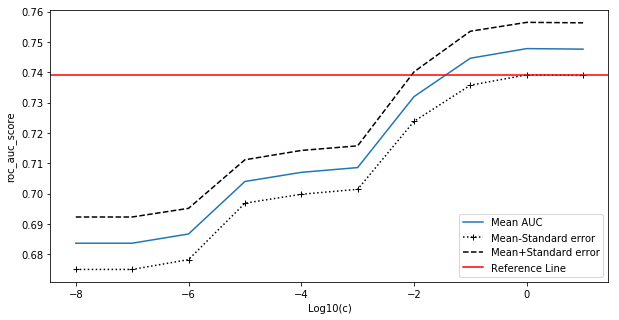

In [0]:
from scipy.stats import sem
import matplotlib.pyplot as plt
import pprint

c_val = np.power(10,np.arange(-8.0,2.0))
aucs=xValSVM(data_train,"Y",10,c_val)
# pprint.pprint(aucs)

alldiff=list()
allmeans=list()
allstderr=list()
for i in aucs.keys():
    mean=np.mean(aucs[i])
    stderr=sem(aucs[i])
    # print("Mean for",i,":",mean," Std. Err: ",stderr)
    allmeans.append(mean)
    allstderr.append(stderr)
    alldiff.append(mean-stderr)
print("Maximum difference:", max(alldiff)," for C value",list(aucs.keys())[(alldiff.index(max(alldiff)))])

plt.figure(figsize=(10,5))
plt.plot(np.log10(c_val),allmeans,label='Mean AUC')
plt.plot(np.log10(c_val),np.array(allmeans)-np.array(allstderr),'k+:',label='Mean-Standard error')
plt.plot(np.log10(c_val),np.array(allmeans)+np.array(allstderr),'k--',label='Mean+Standard error')
plt.axhline(y=max(alldiff),color='r',label='Reference Line')
plt.legend(loc='lower right')
plt.xlabel('Log10(c)')
plt.ylabel('roc_auc_score')
plt.show()

Yes, our optimised model beats the out-of-box SVM model. However, we observe a only marginal increase in the AUC value. Out-of-box SVM with C=1.0 gives us an AUC of 0.5757 while our optimised SVM with C=10.0 gives us an AUC of 0.5768.

### Part 4: Learning Curve with Bootstrapping
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [0]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'Y'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)]
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target])
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = SVC(kernel='linear', C = 0.1) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p))
    
    return [np.mean(aucs_boot), sem(aucs_boot)]

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


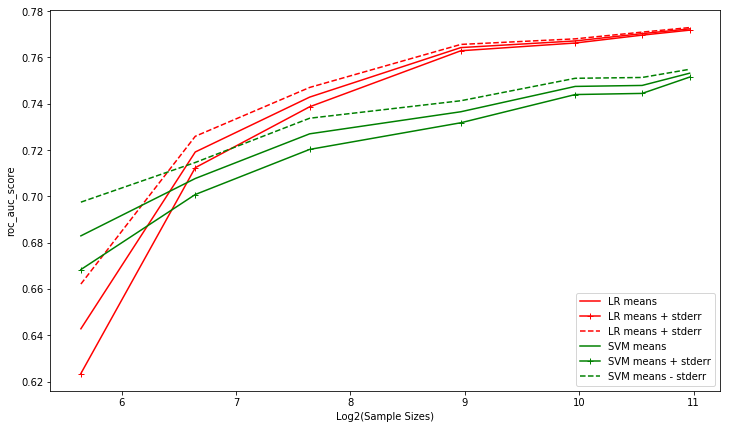

In [0]:
import warnings
warnings.filterwarnings('ignore')

SampleSizes = [50, 100, 200, 500, 1000, 1500, 2000]

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(data_train, data_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(data_train, data_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
plt.figure(figsize=(12,7))   
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


For smaller sample sizes, we prefer SVM over Logistic regression. By using SVM, we gain a chance to obtain a marginally better result than Logistic. The intervals that bind the average case of SVM cover a higher value of AUC but are also lower than the lower bound of Logistic.

If the cost is twice the investment to run experiments to double the data, we can surely choose Logistic regression as the accuracy gain by SVM is only marginal (0.01% approx). For cases where accuracy is precious, such as in healthcare industry, we can adopt SVM as we need all the extra precision that we can get to prevent wrong predictions.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?





Cross validation is used to remove bias from the dataset but it results in an increase in variance. To remove or reduce bias, we take the value of K to be generally three or greater. In this case, we took the cross-validation as K = 10. This results in the development of a model that exhibits low bias due to repeated sampling and averaging of results. Due to this reason, we can safely say that cross-validation is not biased.